# Breast Cancer Classification

Data is from the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). We use a DNN, attempting to avoid overfitting through three attempts. In each attempt, we chart the loss function on the training and validation sets.

1. Using a straightforward DNN, which overfits miserably.

2. Early stopping, which prevents overfitting but results in a significant disparity between the performance on the train and test sets.

3. Using Dropout, which resolves overfitting and achieves an overall accuracy of **95%**.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/cancer_classification.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


### Exploring Data

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='benign_0__mal_1', ylabel='count'>

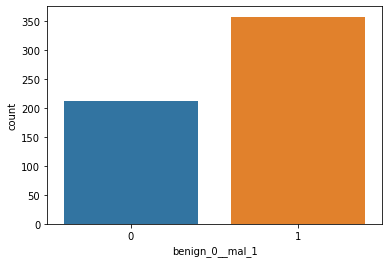

In [5]:
sns.countplot(x='benign_0__mal_1',data=df)

<AxesSubplot:>

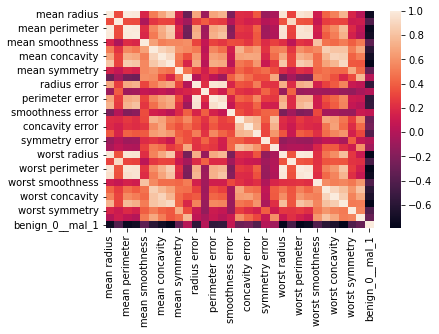

In [6]:
sns.heatmap(df.corr())

<AxesSubplot:>

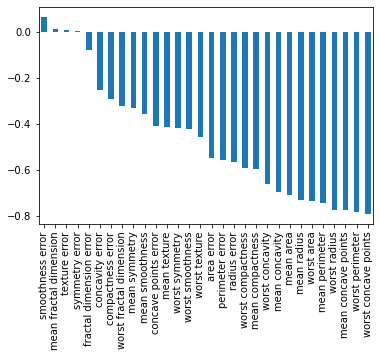

In [7]:
df.corr()['benign_0__mal_1'].sort_values(ascending=False)[1:].plot(kind='bar')

## Creating and Training a Model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.drop('benign_0__mal_1',axis=1).values
y = df['benign_0__mal_1'].values

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.25, random_state=101)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Attempt 1: Too many epochs $\to$ overfitting

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [10]:
model = Sequential()

model.add(Dense(units=30,activation='relu'))
model.add(Dense(units=15,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [11]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/600
14/14 [==============================] - 2s 28ms/step - loss: 0.6574 - val_loss: 0.6383
Epoch 2/600
14/14 [==============================] - 0s 4ms/step - loss: 0.6156 - val_loss: 0.5981
Epoch 3/600
14/14 [==============================] - 0s 4ms/step - loss: 0.5782 - val_loss: 0.5599
Epoch 4/600
14/14 [==============================] - 0s 5ms/step - loss: 0.5385 - val_loss: 0.5149
Epoch 5/600
14/14 [==============================] - 0s 5ms/step - loss: 0.4947 - val_loss: 0.4714
Epoch 6/600
14/14 [==============================] - 0s 5ms/step - loss: 0.4510 - val_loss: 0.4269
Epoch 7/600
14/14 [==============================] - 0s 4ms/step - loss: 0.4078 - val_loss: 0.3817
Epoch 8/600
14/14 [==============================] - 0s 4ms/step - loss: 0.3673 - val_loss: 0.3433
Epoch 9/600
14/14 [==============================] - 0s 5ms/step - loss: 0.3297 - val_loss: 0.3068
Epoch 10/600
14/14 [==============================] - 0s 5ms/step - loss: 0.2924 - val_loss: 0.2726
Epoch 11

In [12]:
model_loss = pd.DataFrame(model.history.history)

In [13]:
model_loss.head()

,loss,val_loss
0,0.657440,0.638253
1,0.615598,0.598134
2,0.578179,0.559925
3,0.538482,0.514882
4,0.494668,0.471362


<AxesSubplot:>

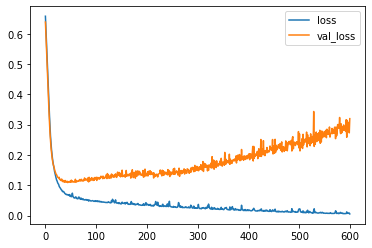

In [14]:
model_loss.plot()

### Attempt 2: Early Stopping

In [15]:
model = Sequential()

model.add(Dense(units=30,activation='relu'))
model.add(Dense(units=15,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25
                           )

model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
14/14 [==============================] - 1s 12ms/step - loss: 0.6847 - val_loss: 0.6646
Epoch 2/600
14/14 [==============================] - 0s 4ms/step - loss: 0.6509 - val_loss: 0.6316
Epoch 3/600
14/14 [==============================] - 0s 3ms/step - loss: 0.6229 - val_loss: 0.6028
Epoch 4/600
14/14 [==============================] - 0s 4ms/step - loss: 0.5946 - val_loss: 0.5750
Epoch 5/600
14/14 [==============================] - 0s 3ms/step - loss: 0.5667 - val_loss: 0.5440
Epoch 6/600
14/14 [==============================] - 0s 4ms/step - loss: 0.5342 - val_loss: 0.5068
Epoch 7/600
14/14 [==============================] - 0s 4ms/step - loss: 0.4964 - val_loss: 0.4650
Epoch 8/600
14/14 [==============================] - 0s 3ms/step - loss: 0.4532 - val_loss: 0.4209
Epoch 9/600
14/14 [==============================] - 0s 3ms/step - loss: 0.4122 - val_loss: 0.3785
Epoch 10/600
14/14 [==============================] - 0s 3ms/step - loss: 0.3695 - val_loss: 0.3392
Epoch 11

<AxesSubplot:>

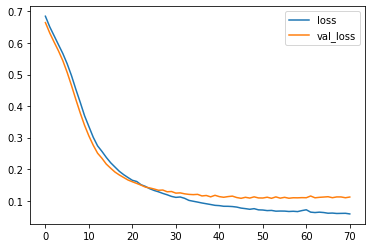

In [17]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

### Attempt 3: Adding Dropout Layers

In [18]:
from tensorflow.keras.layers import Dropout

model = Sequential()

model.add(Dense(units=30,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=15,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [19]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
14/14 [==============================] - 1s 13ms/step - loss: 0.7523 - val_loss: 0.6799
Epoch 2/600
14/14 [==============================] - 0s 4ms/step - loss: 0.7073 - val_loss: 0.6587
Epoch 3/600
14/14 [==============================] - 0s 4ms/step - loss: 0.6722 - val_loss: 0.6538
Epoch 4/600
14/14 [==============================] - 0s 3ms/step - loss: 0.6693 - val_loss: 0.6472
Epoch 5/600
14/14 [==============================] - 0s 4ms/step - loss: 0.6459 - val_loss: 0.6323
Epoch 6/600
14/14 [==============================] - 0s 4ms/step - loss: 0.6399 - val_loss: 0.6142
Epoch 7/600
14/14 [==============================] - 0s 3ms/step - loss: 0.6128 - val_loss: 0.5929
Epoch 8/600
14/14 [==============================] - 0s 4ms/step - loss: 0.6180 - val_loss: 0.5681
Epoch 9/600
14/14 [==============================] - 0s 4ms/step - loss: 0.5812 - val_loss: 0.5414
Epoch 10/600
14/14 [==============================] - 0s 3ms/step - loss: 0.5596 - val_loss: 0.5134
Epoch 11

<AxesSubplot:>

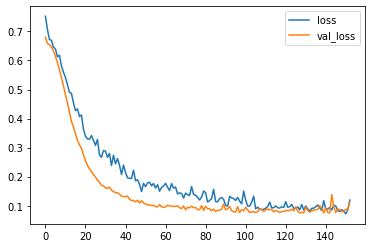

In [20]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

### Evaluating Model

In [21]:
pred = np.round(model.predict(X_test)).astype(int)
pred

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
    

In [22]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,pred))
print(classification_report(y_test, pred))

[[54  1]
 [ 6 82]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        55
           1       0.99      0.93      0.96        88

    accuracy                           0.95       143
   macro avg       0.94      0.96      0.95       143
weighted avg       0.95      0.95      0.95       143

